In [1]:
require(tidyverse)
require(rstan)
require(ggplot2)
require(mvtnorm)
rstan_options(auto_write = TRUE)
require(bayesplot)
missing_val=-100

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: rstan

Loading required package: StanHeaders

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: mvtnorm

Loading required package: bayesplot

This is bayesplot version 1.7.1

- Online documentation and v

In [2]:
path = file.path('/nfs/turbo/umms-cgillies/cgillies/RACE_CAPS/analysis', '/20200728_stage_impute_beta_missing_min_PRIOR_SD')
dir.create(path)
setwd(path)

In [3]:
df_nmr = read_csv('/nfs/turbo/umms-cgillies/cgillies/RACE_CAPS/11_20_2019_even_odds_interaction_prior_1/nmr_metabolites_scaled_matrix.csv')
metabolites = colnames(df_nmr)[1:27]

Parsed with column specification:
cols(
  .default = col_double()
)

See spec(...) for full column specifications.



In [4]:
#TARGET_MISSING_RATE=0.3
get_alpha_beta_for_target_rate = function(df,metabolites,TARGET_MISSING_RATE) {
    missing_rate = df_nmr[,metabolites] %>% summarise_all(function(x) { mean(x == min(x))  })
    missing_rate_numeric = missing_rate %>% t() %>% as.numeric
    mu = mean( missing_rate_numeric )
    sigma_2 = var(missing_rate_numeric)
    RATE = TARGET_MISSING_RATE/mu
    mu = RATE * mu
    sigma_2 = RATE * sigma_2
    mu
    sigma_2
    nu = mu * (1 - mu) / sigma_2 - 1
    alpha = mu * nu
    beta = (1 - mu) * nu
    list(alpha=alpha,beta=beta,mu=mu,sigma_2=sigma_2)
}

get_alpha_beta_for_target_rate(df_nmr,metabolites,0.3)

$alpha
[1] 2.435085

$beta
[1] 5.681866

$mu
[1] 0.3

$sigma_2
[1] 0.02303402

In [5]:
died = df_nmr$died_90_day
sigma_0 = cov(df_nmr[died == 0,c(1:27)])
mu_0 = colMeans(df_nmr[died == 0,c(1:27)]) 
sigma_1 = cov(df_nmr[died == 1,c(1:27)])
mu_1 = colMeans(df_nmr[died == 1,c(1:27)]) 

### Generation code

In [6]:
make_df = function(n_0,mu_0,sigma_0,n_1,mu_1,sigma_1,frac_sig=0.5,censor=TRUE,max_missing=0.6,alpha=-1,beta=-1) {
    diffs = abs( mu_1 - mu_0) / sqrt( (diag(sigma_0)^2)/n_0 + (diag(sigma_1)^2)/n_1  )
    #print(diffs)
    m = length(diffs)
    diffs = diffs/sum(diffs)
    #print(diffs)
    ind = seq(1,m)
    set_non_zero = sample(ind,size=ceiling(frac_sig * m),prob=diffs)
    set_zero = setdiff(ind,set_non_zero)
    truth = rep(FALSE,m)
    truth[set_non_zero] = TRUE
    mu_0[set_zero] = 0
    mu_1[set_zero] = 0
    X_0 = rmvnorm(n = n_0, mean = mu_0, sigma = sigma_0) 
    X_1 = rmvnorm(n = n_1, mean = mu_1, sigma = sigma_1)
    df_sample = data.frame(rbind(X_0,X_1))
    df_sample$died_90_day = c( rep(0,n_0),rep(1,n_1)  )
    
    df_censored = df_sample
    df_naive_impute = df_sample
    n_var = length(mu_0)
    thresholds = rep(0,n_var)
    est.thresholds = rep(0,n_var)
    est.naive_impute = rep(0,n_var)
    missing_rates=rep(0,n_var)
    if(censor == TRUE) {
        
        missing_rates = rbeta(n_var,shape1 = alpha, shape2 = beta)
        # only allow a missing rate up to a certain level
        missing_rates = sapply(missing_rates, function(x) { min(max_missing,x) })
        
        #missing_rates = rep(MISSING_RATE, n_var)
        
        for(i in 1:n_var) {
            thresholds[i] = quantile( df_censored[, i], missing_rates[i] )
            df_censored[ (df_censored[, i] < thresholds[i]), i ] = NA
            est.thresholds[i] = min( df_censored[ , i ], na.rm = T)
            est.naive_impute[i] = log( min( exp(df_censored[ , i ]), na.rm = T) / 2 )
            df_naive_impute[ (df_naive_impute[, i] < thresholds[i]), i ] = est.thresholds[i]
        }
    }
    
    
    list(df_sample=df_sample,truth=truth, df_censored=df_censored, df_naive_impute=df_naive_impute, missing_rates=missing_rates, thresholds=thresholds, est.thresholds=est.thresholds, est.naive_impute=est.naive_impute)
}

### Stage 1 Imputation model

In [7]:
stage_1_impute = "
functions {
    real normal_ub_rng(real mu, real sigma, real ub) {
      real p_ub = normal_cdf(ub, mu, sigma);
      real u = uniform_rng(0, p_ub);
      real y = mu + sigma * inv_Phi(u);
      return y;
    }
}
data {
    int<lower=0> N;
    int<lower=0> N_var;
    int<lower=0> N_miss;
    int<lower=0> N_use_impute;

    matrix[ N, N_var ] x_naive_impute;
    matrix[ N, N_var ] x_is_missing;

    //contains the indicies of x_naive_imp to use for imputation
    int x_use_impute[N_use_impute, N_var ];

    //Threshold for imputation
    //Separate threshold per metabolite
    vector[N_var] threshold;
    

    // This vector contains the missing row index, column index
    int x_missing[ N_miss, 2 ];
    
}
parameters {

    //betas for each imputed value
    matrix[ N_use_impute, N_var ] beta_impute_raw;
    vector[ N_var ] alpha_impute;
    vector<lower=0>[ N_var ] sigma_impute;
    real<lower=0> sigma_beta_impute_x;

}
transformed parameters {
    matrix[ N_use_impute, N_var ] beta_impute;
    for(j in 1:N_var) {
        beta_impute[,j] = beta_impute_raw[,j] * sigma_beta_impute_x;
    }
}
model {
    sigma_beta_impute_x ~ std_normal();
    // FORGOT TO SET PRIOR ON alpha_x_pred and sigma_impute

    for(j in 1:N_var) {
        real y[N];
        vector[N_use_impute] beta_x_pred;
        int x_use_ind[N_use_impute];
        matrix[N, N_use_impute] x_pred_use;
        real alpha_x_pred;
        real sigma_x_pred;
        //predicted target
        vector[N] xj_pred;
        //target
        vector[N] xj;
        int observed[N];
        
        //ADD TO LIKELIHOOD
        beta_impute_raw[, j] ~ std_normal();
    
        //ASSIGN VALS
        xj = x_naive_impute[, j];
        //dont make a prediction using itself
        //this should be copying the values according to ref
        beta_x_pred = beta_impute[, j];
        alpha_x_pred = alpha_impute[j];
        x_use_ind = x_use_impute[, j];
        sigma_x_pred = sigma_impute[j];
        x_pred_use = x_naive_impute[, x_use_ind];
        
        //Make pred
        xj_pred = x_pred_use * beta_x_pred + alpha_x_pred;
        
        
        //observed = (x_is_missing[, j] == 0);
        
        // target +=  normal_lpdf(xj | xj_pred, sigma_x_pred);

        for(i in 1:N) {
            real mu_x_pred;
            mu_x_pred = xj_pred[i];
            if( x_is_missing[i,j] == 0) {
                // if observed use pdf for observed value
                target +=  normal_lpdf(xj[i] | mu_x_pred, sigma_x_pred);
            } else {
                // if censored, use normal CDF
                target +=  normal_lcdf(threshold[j] | mu_x_pred, sigma_x_pred);
            }
        }
    }
}
generated quantities {
    real x_impute_mean[ N_miss ];
    real x_impute[ N_miss ];

    for(i in 1:N_miss) {
        //These correspond to the rows and columns in the original data frame
        int metab_row;
        int metab_col;
        row_vector[N_use_impute] x_pred_use;
        vector[N_use_impute] beta_x_pred;
        real alpha_x_pred;
        int x_use_ind[N_use_impute];
        real mu_x;
        real sd_x;
        real ub_x;

        metab_row = x_missing[i,1];
        metab_col = x_missing[i,2];
        x_use_ind = x_use_impute[, metab_col ];
        beta_x_pred = beta_impute[, metab_col ];
        alpha_x_pred = alpha_impute[ metab_col ];
        x_pred_use = x_naive_impute[metab_row, x_use_ind];

        mu_x = x_pred_use * beta_x_pred + alpha_x_pred;
        sd_x =  sigma_impute[ metab_col ];
        ub_x = threshold[ metab_col ];
        x_impute_mean[ i ] = mu_x;
        x_impute[i] = normal_ub_rng(mu_x, sd_x, ub_x);
    }
}

"

In [8]:
stage_1_impute_code_file = 'stage_1_impute.stan'
write_lines(x = stage_1_impute, path = stage_1_impute_code_file)
stage_1_impute_model = stan_model(file = stage_1_impute_code_file, verbose = FALSE)

In [9]:
stage_1_impute_get_init_vals = function(data) {
    n_var = data$N_var
    N_use_impute = data$N_use_impute
    # matrix[ N_use_impute, N_var ] beta_impute_raw;
    beta_impute_raw = matrix( rep(0, data$N_use_impute * n_var), ncol=n_var)
    alpha_impute = rep(0,n_var)
    x_use_impute = data$x_use_impute
    sigma_impute = rep(1, n_var)
    
    for(i in 1:n_var) {
        x_imp_vals_use = data$x_naive_impute[, x_use_impute[,i]   ]
        y_out_imp = data$x_naive_impute[,i]
        m_out = glm(y_out_imp ~ x_imp_vals_use,family="gaussian")
        coefs_imp = summary(m_out)$coef
        alpha_impute[i] = coefs_imp[1,1]
        for(k in 1:N_use_impute) {
            beta_impute_raw[k,i] = coefs_imp[1 + k,1]
        }
        sigma_impute[i] = sum(m_out$residuals^2) / m_out$df.residual
    }
    
    sigma_beta_impute_x = sqrt( sum( beta_impute_raw^2 ) / (prod(dim(beta_impute_raw)) - 1) ) 
    
    inits = list(
        sigma_impute = sigma_impute,
        sigma_beta_impute_x = sigma_beta_impute_x,
        alpha_impute = alpha_impute,
        beta_impute_raw = beta_impute_raw / sigma_beta_impute_x
    )
    
    inits
    
}

In [10]:
stage_1_impute_make_data = function(x_censored, y, threshold=NULL,
                                         N_use_impute=8) {
    
    if(is.null(threshold)) {
        threshold = apply(x_censored,MARGIN=2,FUN=function(x) { min(x,na.rm = T)})
    }
    
    naive_impute_val = log( exp(threshold) / 2)
    
    n = dim(x_censored)[1]
    N_var = dim(x_censored)[2]
    N_miss = sum(is.na(x_censored))
    
    x_naive_impute = x_censored %>% select_all()
    x_is_missing = apply( is.na(x_censored), FUN=as.numeric, MARGIN=c(1,2))             
    for(j in 1:N_var) {
        x_naive_impute[is.na(x_naive_impute[,j]),j] = naive_impute_val[j]
    }            
    # create a matrix that contains the N_use_impute indicies of the most correlated
    # variables with the metabolite of interest
    # each column contains a metabolite corresponding with x_censored
    # each row corresponds to the index of the metabolite most correlated with it up to N_use_impute
    # rows
    var_cors = cor(x_naive_impute,use = "complete")
    diag(var_cors) = 0
    get_inds_to_use_per_metabolite = function(x) { which( rank(-abs(x)) <= N_use_impute)   }
    x_use_impute = apply(var_cors,MARGIN=1,FUN=get_inds_to_use_per_metabolite )

    x_censored[is.na(x_censored)] = missing_val

    x_censored = as.matrix(x_censored)
    x_missing = matrix(nrow = N_miss, ncol = 2)
    x_missing_init = rep(0,N_miss)
    x_missing_init_raw = rep(0,N_miss)
    
    # make a table were the first column is the row number in x_censored
    # second column contains the metabolite column number in x_censored
    col1 = c()
    col2 = c()
    for(j in 1:dim(x_censored)[2]) {
        missing_in_col = which(x_censored[,j] == missing_val)
        col1 = c(col1, missing_in_col)
        col2 = c(col2, rep(j,length(missing_in_col)))
    }
    x_missing[,1] = col1
    x_missing[,2] = col2
    
    if( N_miss > 0 ) {
        # make a vector with naive imputation values
        for(i in 1:dim(x_missing)[1]) {
            row = x_missing[i,1]
            col = x_missing[i,2]
            x_missing_init[i] = x_naive_impute[row,col]
            x_missing_init_raw[i] = x_missing_init[i] - threshold[col]
        }
    }

    data = list(
            N = n,
            N_miss = N_miss,
            N_var = N_var,
            x_raw = x_censored,
            x_naive_impute = as.matrix(x_naive_impute),
            N_use_impute = N_use_impute,
            x_use_impute = x_use_impute,
            x_missing = x_missing,
            x_missing_init = x_missing_init,
            x_missing_init_raw = x_missing_init_raw,
            x_is_missing = x_is_missing,
            threshold = threshold,
            y=y
        )

    #str(data)
    #mean(x_censored == missing_val)
    #data$N_miss / (data$N * data$N_var)

    data   
}


In [11]:
replicate_init = function(init_data,chains=4) {
    init = list()
    for(i in 1:chains){
        init[paste0(i)] = list(init_data)
    }
    init
} 

In [12]:
set.seed(0)
n_0=100
n_1=100
beta_params = get_alpha_beta_for_target_rate(df_nmr,metabolites,TARGET_MISSING_RATE = 0.3)
#out = make_df(n_0,mu_0,sigma_0,n_1,mu_1,sigma_1,frac_sig=0.4,censor=TRUE,
#                  max_missing = 0.4, alpha = beta_params$alpha, beta=beta_params$beta)

out = make_df(n_0,mu_0,sigma_0,n_1,mu_1,sigma_1,frac_sig=0.4,censor=FALSE,
                  max_missing = 0.4, alpha = beta_params$alpha, beta=beta_params$beta)


write_rds(out,'debug_df.rds')

x_censored = out$df_censored[,metabolites]
y=out$df_censored$died_90_day
sum(is.na(x_censored))

stage_1_data = stage_1_impute_make_data(x_censored, y, N_use_impute=8)
stage_1_init_data = replicate_init(
        stage_1_impute_get_init_vals(stage_1_data), chains=1
    )
str(stage_1_data)

[1] 0

List of 13
 $ N                 : int 200
 $ N_miss            : int 0
 $ N_var             : int 27
 $ x_raw             : num [1:200, 1:27] -0.2539 0.1963 0.0995 1.0577 -0.5308 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:27] "hydroxybutyrate" "oxoisocaproate" "X3.hydoxybutyrate" "alanine" ...
 $ x_naive_impute    : num [1:200, 1:27] -0.2539 0.1963 0.0995 1.0577 -0.5308 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:27] "hydroxybutyrate" "oxoisocaproate" "X3.hydoxybutyrate" "alanine" ...
 $ N_use_impute      : num 8
 $ x_use_impute      : int [1:8, 1:27] 3 15 17 18 19 22 26 27 1 4 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:27] "hydroxybutyrate" "oxoisocaproate" "X3.hydoxybutyrate" "alanine" ...
 $ x_missing         : int[0 , 1:2] 
 $ x_missing_init    : num(0) 
 $ x_missing_init_raw: num(0) 
 $ x_is_missing      : num [1:200, 1:27] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..

In [13]:
stage_1_fit = sampling(stage_1_impute_model,  data = stage_1_data, init=stage_1_init_data, cores=1, chains=1, iter = 2000, control=list(adapt_delta=0.8))



SAMPLING FOR MODEL 'stage_1_impute' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 68.42 seconds (Warm-up)
Chain 1:                45.1 seconds (Sampling)
Chain 1:                113.52 sec

In [14]:
df_sum = data.frame(summary(stage_1_fit)$summary) 
df_sum$PARAM = rownames(summary(stage_1_fit)$summary)
df_sum %>% arrange(n_eff) %>% head(10)
df_sum %>% arrange(-abs(Rhat)) %>% head(10)

,mean,se_mean,sd,X2.5.,X25.,X50.,X75.,X97.5.,n_eff,Rhat,PARAM
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,-5512.6520737,1.1956927349,16.06832048,-5.543797e+03,-5.523679e+03,-5513.1013050,-5501.2417105,-5480.7377332,180.5934,0.9995295,lp__
2,0.1972392,0.0006506298,0.01056270,1.780939e-01,1.895429e-01,0.1964747,0.2043881,0.2188030,263.5613,0.9991405,sigma_beta_impute_x
3,3.6329327,0.0134496092,0.27568563,3.097374e+00,3.445525e+00,3.6250536,3.8110687,4.1945714,420.1544,0.9991785,"beta_impute_raw[7,16]"
4,4.3375261,0.0148969168,0.31698955,3.720797e+00,4.117323e+00,4.3296303,4.5447819,4.9611346,452.7903,0.9990645,"beta_impute_raw[7,25]"
5,3.3370878,0.0127093304,0.28440287,2.791659e+00,3.141564e+00,3.3299810,3.5263381,3.9184802,500.7519,0.9997764,"beta_impute_raw[8,17]"
6,3.4715000,0.0103898173,0.31538750,2.843631e+00,3.245802e+00,3.4727668,3.6934118,4.0503065,921.4529,0.9993288,"beta_impute_raw[5,27]"
7,1.4982265,0.0069840063,0.22234685,1.061910e+00,1.343338e+00,1.5059335,1.6490110,1.9177824,1013.5676,0.9995534,"beta_impute_raw[4,4]"
8,0.5832399,0.0092835255,0.30322833,2.510396e-02,3.715368e-01,0.5748025,0.7738567,1.2013517,1066.8754,0.9990317,"beta_impute_raw[6,4]"
9,0.1147143,0.0017639371,0.05902539,5.266292e-03,7.296193e-02,0.1127369,0.1549204,0.2334397,1119.7256,0.9990989,"beta_impute[6,4]"


,mean,se_mean,sd,X2.5.,X25.,X50.,X75.,X97.5.,n_eff,Rhat,PARAM
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.51640867,0.011842587,0.41118668,-0.30030119,0.25400458,0.48908695,0.787742967,1.36391972,1205.549,1.003561,"beta_impute_raw[3,21]"
2,0.23161804,0.001574323,0.07256845,0.08728896,0.18406437,0.23234613,0.278254824,0.37151915,2124.750,1.003547,"beta_impute[1,9]"
3,0.10170174,0.002306241,0.08079381,-0.05972333,0.04961109,0.09612933,0.154734287,0.26551895,1227.289,1.003540,"beta_impute[3,21]"
4,-0.22552211,0.009534655,0.38590639,-0.98936137,-0.48054038,-0.23625986,0.036739931,0.49465571,1638.151,1.003409,"beta_impute_raw[6,21]"
5,-0.04452559,0.001859412,0.07585322,-0.19545827,-0.09451529,-0.04647340,0.007485014,0.09729545,1664.167,1.003375,"beta_impute[6,21]"
6,1.17621741,0.008417771,0.36959853,0.44055025,0.92927941,1.17041269,1.418843823,1.93140420,1927.819,1.002851,"beta_impute_raw[1,9]"
7,-0.11382482,0.006487158,0.28030502,-0.68483057,-0.29978539,-0.10539689,0.056003849,0.42525222,1867.037,1.002350,"beta_impute_raw[4,16]"
8,-0.02235305,0.001294869,0.05498725,-0.13486865,-0.05828562,-0.02075392,0.011042828,0.08294994,1803.319,1.002322,"beta_impute[4,16]"
9,0.79403343,0.008869983,0.38462335,0.06309948,0.53065739,0.77645881,1.070965202,1.53488170,1880.294,1.002314,"beta_impute_raw[5,24]"


### Stage 2 regression code

In [15]:
stage_2_regress = "
data {
    int<lower=0> N;
    int<lower=0> N_var;
    int<lower=0> N_miss;

    matrix[ N, N_var ] x_raw;

    int<lower=0,upper=1> y[N];

    //Threshold for imputation
    //Separate threshold per metabolite
    vector[N_var] threshold;
    
    // This vector contains the missing row index, column index
    int x_missing[ N_miss, 2 ];
    real x_missing_mean[ N_miss ];
    real x_missing_sd[ N_miss ];
    real<lower=0> sigma_beta_x_lower_bound;
}
parameters {
    // Needed for imputation
    vector<upper=0>[ N_miss ] x_impute_raw;
    
    //regression on y per metabolite in x_raw columns
    vector[N_var] beta_x;
    vector[N_var] alpha_x;

    real<lower=sigma_beta_x_lower_bound> sigma_beta_x;
    real<lower=1> nu_x;

}
transformed parameters {
    // https://mc-stan.org/docs/2_18/stan-users-guide/vectors-with-varying-bounds.html
    vector<upper=0>[ N_miss ] x_impute;
    x_impute = x_impute_raw;
    for(i in 1:N_miss) {
        int metab_row = x_missing[i,1];
        int metab_col = x_missing[i,2];
        x_impute[i] = x_impute[i] + threshold[metab_col];
    }

}
model {
    matrix[N, N_var] x_merge;
    //copy matrix
    x_merge = x_raw;
    
    //fill in the values we are going to impute
    for(i in 1:N_miss) {
        int metab_row = x_missing[i,1];
        int metab_col = x_missing[i,2];
        x_merge[metab_row,metab_col] = x_impute[ i ];
    }
    
    x_impute ~ normal(x_missing_mean, x_missing_sd);
    
    sigma_beta_x ~ cauchy(0,1);
    nu_x ~ gamma(2,0.1);
    beta_x ~  student_t(nu_x,0,sigma_beta_x);
    alpha_x ~ normal(0,5);
    
    for(j in 1:N_var) {
        vector[N] x_col = x_merge[ , j];
        real beta = beta_x[j];
        real alpha = alpha_x[j];
        y ~ bernoulli_logit(alpha + beta * x_col);
    }
}

"

In [16]:
stage_2_regress_code_file = 'stage_2_regress.stan'
write_lines(x = stage_2_regress, path = stage_2_regress_code_file)
stage_2_regress_model = stan_model(file = stage_2_regress_code_file, verbose = FALSE)

DIAGNOSTIC(S) FROM PARSER:
Info:
Left-hand side of sampling statement (~) may contain a non-linear transform of a parameter or local variable.
If it does, you need to include a target += statement with the log absolute determinant of the Jacobian of the transform.
Left-hand-side of sampling statement:
    x_impute ~ normal(...)



In [39]:
###
# This function formats the data for
###

default_impute = function(x_censored, x_missing) {
    N_miss = dim(x_missing)[1]
    #print(N_miss)
    x_missing_mean = rep(0,N_miss)
    x_missing_sd = rep(1,N_miss)
    
    list(
         x_missing_mean=x_missing_mean,
         x_missing_sd=x_missing_sd
        )
}

stage_2_regress_make_data = function(x_censored, y, IMPUTE_FUNC=default_impute, threshold=NULL, sigma_beta_x_lower_bound=0.1, ...) {
    
    if(is.null(threshold)) {
        threshold = apply(x_censored,MARGIN=2,FUN=function(x) { min(x,na.rm = T)})
    }
    
    naive_impute_val = log( exp(threshold) / 2)
    
    n = dim(x_censored)[1]
    N_var = dim(x_censored)[2]
    N_miss = sum(is.na(x_censored))
    
    x_naive_impute = x_censored %>% select_all()
                 
    for(j in 1:N_var) {
        x_naive_impute[is.na(x_naive_impute[,j]),j] = naive_impute_val[j]
    }            


    x_censored[is.na(x_censored)] = missing_val

    x_censored = as.matrix(x_censored)
    x_missing = matrix(nrow = N_miss, ncol = 2)
    x_missing_init = rep(0,N_miss)
    x_missing_init_raw = rep(0,N_miss)
    x_missing_mean = rep(0,N_miss)
    x_missing_sd = rep(1,N_miss)
    
    # make a table were the first column is the row number in x_censored
    # second column contains the metabolite column number in x_censored
    col1 = c()
    col2 = c()
    for(j in 1:dim(x_censored)[2]) {
        missing_in_col = which(x_censored[,j] == missing_val)
        col1 = c(col1, missing_in_col)
        col2 = c(col2, rep(j,length(missing_in_col)))
    }
    x_missing[,1] = col1
    x_missing[,2] = col2
    
    # make a vector with naive imputation values
    if( N_miss > 0 ) {
        for(i in 1:dim(x_missing)[1]) {
            row = x_missing[i,1]
            col = x_missing[i,2]
            x_missing_init[i] = x_naive_impute[row,col]
            x_missing_init_raw[i] = x_missing_init[i] - threshold[col]
        }
    
        mean_sds = IMPUTE_FUNC(x_censored,x_missing,...)
        x_missing_mean = mean_sds$x_missing_mean
        x_missing_sd = mean_sds$x_missing_sd
    }
    
    data = list(
            N = n,
            N_miss = N_miss,
            N_var = N_var,
            x_raw = x_censored,
            x_naive_impute = as.matrix(x_naive_impute),
            x_missing = x_missing,
            x_missing_init = x_missing_init,
            x_missing_init_raw = x_missing_init_raw,
            x_missing_mean=x_missing_mean,
            x_missing_sd=x_missing_sd,
            threshold = threshold,
            y=y,
            sigma_beta_x_lower_bound=sigma_beta_x_lower_bound
        )

    #str(data)
    #mean(x_censored == missing_val)
    #data$N_miss / (data$N * data$N_var)

    data   
}


In [18]:
stage_1_impute = function(x_censored, x_missing, stage_1_post=NULL) {
    N_miss = dim(x_missing)[1]
    print(N_miss)
    x_missing_mean = apply( stage_1_post$x_impute_mean, FUN=mean, MARGIN=2 )
    x_missing_sd = apply( stage_1_post$x_impute, FUN=sd, MARGIN=2 )
            
    list(
         x_missing_mean=x_missing_mean,
         x_missing_sd=x_missing_sd
        )
}

fancy_impute = function(x_censored, x_missing) {
    N_miss = dim(x_missing)[1]
    #print(N_miss)
    x_missing_mean = rep(0,N_miss)
    x_missing_sd = rep(1,N_miss)
    
    
    x_obs = out$df_sample[,metabolites]
    for(i in 1:N_miss) {
        row = x_missing[i,1]
        col = x_missing[i,2]
        x_missing_mean[i] = x_obs[row,col]
        x_missing_sd[i] = 0.001
    }
            
    list(
         x_missing_mean=x_missing_mean,
         x_missing_sd=x_missing_sd
        )
}

stage_1_post = extract(stage_1_fit)
stage_2_data = stage_2_regress_make_data(x_censored, y, IMPUTE_FUNC = stage_1_impute, stage_1_post=stage_1_post)
#stage_2_init = list(
#    x_impute_raw = stage_2_data$x_missing_init_raw
#)


stage_2_init = replicate_init(
    list(
        x_impute_raw = stage_2_data$x_missing_init_raw
    ), chains=4
)


In [19]:
str(stage_2_data)
str(stage_2_init)

List of 13
 $ N                       : int 200
 $ N_miss                  : int 0
 $ N_var                   : int 27
 $ x_raw                   : num [1:200, 1:27] -0.2539 0.1963 0.0995 1.0577 -0.5308 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:27] "hydroxybutyrate" "oxoisocaproate" "X3.hydoxybutyrate" "alanine" ...
 $ x_naive_impute          : num [1:200, 1:27] -0.2539 0.1963 0.0995 1.0577 -0.5308 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:27] "hydroxybutyrate" "oxoisocaproate" "X3.hydoxybutyrate" "alanine" ...
 $ x_missing               : int[0 , 1:2] 
 $ x_missing_init          : num(0) 
 $ x_missing_init_raw      : num(0) 
 $ x_missing_mean          : num(0) 
 $ x_missing_sd            : num(0) 
 $ threshold               : Named num [1:27] -2.4 -2.11 -3.15 -2.4 -2.32 ...
  ..- attr(*, "names")= chr [1:27] "hydroxybutyrate" "oxoisocaproate" "X3.hydoxybutyrate" "alanine" ...
 $ y                       : num [1:200] 0 0 0

In [20]:
#stage_2_data$threshold
sum(apply(x_censored,FUN=function(x) { sum(is.na(x))},MARGIN=2))
x_censored[ stage_2_data$x_missing %>% head ]
out$df_sample[ stage_2_data$x_missing %>% head ]
stage_2_data$x_missing_mean[1:5]

[1] 0

numeric(0)

numeric(0)

[1] NA NA NA NA NA

In [21]:
stage_2_fit = sampling(stage_2_regress_model,  data = stage_2_data, init=stage_2_init, cores=4, chains=4, iter = 2000, control=list(adapt_delta=0.8))


In [22]:
df_sum = data.frame(summary(stage_2_fit)$summary) 
df_sum$PARAM = rownames(summary(stage_2_fit)$summary)
df_sum %>% arrange(n_eff)

mean,se_mean,sd,X2.5.,X25.,X50.,X75.,X97.5.,n_eff,Rhat,PARAM
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
-3.694043e+03,0.139065514,5.39343410,-3.705574e+03,-3.697444e+03,-3.693760e+03,-3.690293e+03,-3684.3347002,1504.152,1.0021703,lp__
2.681259e-01,0.001483467,0.05872571,1.609705e-01,2.293913e-01,2.645376e-01,3.036082e-01,0.3939789,1567.115,1.0029695,sigma_beta_x
1.878750e+01,0.219294548,13.62029644,2.406392e+00,8.568944e+00,1.574409e+01,2.560232e+01,52.7420476,3857.602,1.0004976,nu_x
1.811881e-01,0.001816480,0.12429340,-5.513418e-02,9.596770e-02,1.786721e-01,2.645823e-01,0.4317490,4682.038,0.9992651,beta_x[25]
1.931798e-02,0.002043035,0.14244069,-2.639041e-01,-7.673743e-02,1.977823e-02,1.131703e-01,0.3018738,4860.899,0.9994084,alpha_x[25]
4.437609e-03,0.002009471,0.14367672,-2.724323e-01,-9.384180e-02,2.133610e-03,1.019685e-01,0.2853517,5112.219,0.9995786,alpha_x[17]
-5.477411e-03,0.001772377,0.12674483,-2.597522e-01,-9.005103e-02,-3.973641e-03,7.892909e-02,0.2380191,5113.853,0.9999204,beta_x[26]
5.339711e-01,0.002126222,0.15318093,2.426675e-01,4.318015e-01,5.285661e-01,6.336679e-01,0.8526565,5190.296,0.9997843,beta_x[5]
1.880705e-01,0.001803564,0.13038177,-6.292559e-02,9.761283e-02,1.874869e-01,2.740039e-01,0.4439048,5226.013,0.9998307,beta_x[6]


### Run both models

In [23]:
make_summary_table_beta = function(fit,metabolites) {
    df_summary = data.frame(summary(fit)$summary)
    post = rstan::extract(fit)
    #compute prob > 0 or prob < 0
    n_sample = dim(post$beta_x)[1]
    g0 = colSums( (post$beta_x > 0) ) / n_sample 
    l0 = colSums( (post$beta_x < 0) ) / n_sample
    df_prob = data.frame(G0=g0,L0=l0) %>% rowwise() %>% mutate(Max=max(G0,L0))
    beta_names = c()
    for(i in seq(0,dim(post$beta_x)[2])) {
        beta_names=c(beta_names,paste0('beta_x[',i,']'))
    }
    df_summary_beta = df_summary %>% mutate(Param = rownames(.)) %>% 
    filter(Param %in% beta_names) %>% cbind(Metabolite = metabolites, P_GT_LT_0=df_prob$Max) %>%
    mutate(Z=mean/sd) %>% arrange(-P_GT_LT_0, -abs(Z)) %>% select(Metabolite,Param,mean,sd,X2.5.,X50.,X97.5.,Rhat,Z,P_GT_LT_0)
    return(df_summary_beta)   
}

In [24]:
run_bayes_model = function(df_censored,metabolites,cores=4,chains=4,iter=2000, 
                           adapt_delta=0.8,
                           max_treedepth=10) {
    x_censored = df_censored[, metabolites]
    y = df_censored$died_90_day
    
    stage_1_data = stage_1_impute_make_data(x_censored, y, N_use_impute=8)
    stage_1_init_data = replicate_init(
        stage_1_impute_get_init_vals(stage_1_data), chains=4
    )
    
    control = list(adapt_delta=adapt_delta,max_treedepth=max_treedepth)
    print("CONTROL")
    print(control)
    
    N_miss = stage_1_data$N_miss
    stage_1_fit = NULL
    stage_1_post = NULL
    if(N_miss > 0) {
        print("IMPUTING")
        stage_1_fit = sampling(stage_1_impute_model,  data = stage_1_data, init=stage_1_init_data, cores=cores, chains=chains, iter = iter,
                             control = control )

        stage_1_post = extract(stage_1_fit)
    } else {
        print("NO MISING DATA SKIPPING IMPUTATION")
    }
    
    stage_2_data = stage_2_regress_make_data(x_censored, y, IMPUTE_FUNC = stage_1_impute, stage_1_post=stage_1_post)
    stage_2_init = list(
        x_impute_raw = stage_2_data$x_missing_init_raw
    )
    
    stage_2_init = replicate_init(
        list(
            x_impute_raw = stage_2_data$x_missing_init_raw
        ), chains=4
    )
    
    
    stage_2_fit = sampling(stage_2_regress_model,  data = stage_2_data, init=stage_2_init, cores=cores, chains=chains, iter = iter, control = control )

    
    sum_table = make_summary_table_beta(stage_2_fit,metabolites)
    rownames(sum_table) = sum_table$Metabolite
    list( sum_table=sum_table, stage_1_fit=stage_1_fit, stage_2_fit=stage_2_fit)
}

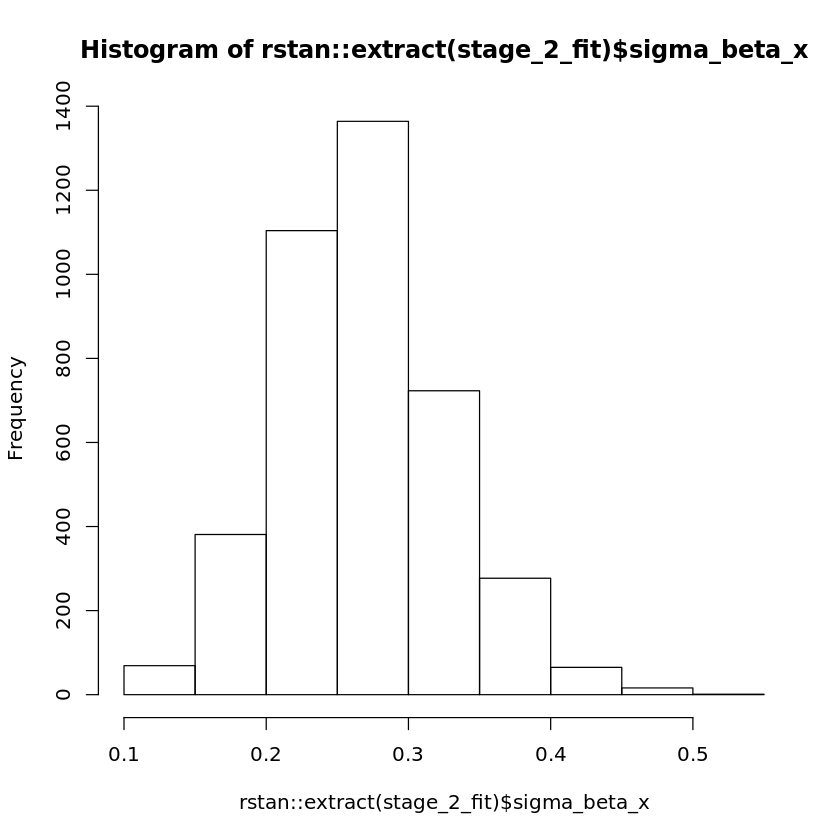

In [38]:
hist(rstan::extract(stage_2_fit)$sigma_beta_x)

In [25]:
make_summary_table_beta(stage_2_fit,metabolites)

Metabolite,Param,mean,sd,X2.5.,X50.,X97.5.,Rhat,Z,P_GT_LT_0
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
oacetylcarnitine,beta_x[20],0.598763494,0.1578067,0.30475169,0.598140772,0.9223027,0.9993473,3.79428367,1.00000
propyleneglycol,beta_x[24],0.551518558,0.1535423,0.26207118,0.548383392,0.8647490,0.9999950,3.59196464,1.00000
glutamine,beta_x[12],0.487380522,0.1441656,0.22271744,0.481716928,0.7833939,0.9991161,3.38069848,1.00000
betaine,beta_x[5],0.533971086,0.1531809,0.24266747,0.528566102,0.8526565,0.9997843,3.48588486,0.99975
proline,beta_x[23],0.447500043,0.1426872,0.17520225,0.448959221,0.7279739,0.9996292,3.13623142,0.99975
alanine,beta_x[4],0.378876157,0.1387734,0.11604238,0.377896924,0.6480720,0.9997851,2.73017810,0.99800
choline,beta_x[7],0.239340931,0.1327409,-0.01179518,0.236823280,0.5027814,0.9997467,1.80306800,0.96950
phenylalanine,beta_x[22],0.231281050,0.1337767,-0.01980816,0.229362220,0.5058789,1.0003192,1.72885950,0.96325
pyruvate,beta_x[25],0.181188076,0.1242934,-0.05513418,0.178672112,0.4317490,0.9992651,1.45774497,0.92575


In [26]:
bayes_model_res = run_bayes_model(out$df_censored,metabolites,cores=4,chains=4,iter=2000, 
                           adapt_delta=0.8,
                           max_treedepth=10)

[1] "CONTROL"
$adapt_delta
[1] 0.8

$max_treedepth
[1] 10

[1] "NO MISING DATA SKIPPING IMPUTATION"


Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”


In [27]:
apply( out$df_censored, FUN=function(x) { mean(is.na(x)) }, MARGIN=1)

[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [38] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [75] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[112] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[149] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[186] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [28]:
names(bayes_model_res)

[1] "sum_table"   "stage_1_fit" "stage_2_fit"

In [29]:
df_sum = data.frame(summary(bayes_model_res$stage_2_fit)$summary) 
df_sum$PARAM = rownames(summary(bayes_model_res$stage_2_fit)$summary)
df_sum %>% arrange(n_eff) %>% head(20)

,mean,se_mean,sd,X2.5.,X25.,X50.,X75.,X97.5.,n_eff,Rhat,PARAM
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2.666445e-01,0.002463678,0.06206117,1.328696e-01,2.268586e-01,2.656609e-01,3.055718e-01,0.3942095,634.5591,1.0052367,sigma_beta_x
2,-3.694297e+03,0.133741148,5.42053654,-3.705736e+03,-3.697910e+03,-3.693998e+03,-3.690474e+03,-3684.5282425,1642.6856,1.0014264,lp__
3,1.821666e+01,0.276770117,13.23803835,2.091644e+00,8.416071e+00,1.527438e+01,2.495248e+01,51.3873414,2287.7516,1.0010776,nu_x
4,1.805063e-01,0.002154834,0.12611408,-6.288948e-02,9.641845e-02,1.776910e-01,2.641735e-01,0.4324445,3425.3061,1.0010220,beta_x[25]
5,6.077589e-01,0.002651654,0.15864941,3.163286e-01,4.977810e-01,6.070426e-01,7.091381e-01,0.9318559,3579.6709,0.9992719,beta_x[20]
6,2.273991e-01,0.002183854,0.13486477,-2.411362e-02,1.357382e-01,2.234030e-01,3.197703e-01,0.4952082,3813.7281,1.0003619,beta_x[22]
7,-1.948684e-03,0.002295566,0.14390505,-2.837969e-01,-9.752990e-02,-2.470209e-03,9.858648e-02,0.2756219,3929.8193,0.9993425,alpha_x[23]
8,1.859764e-01,0.002077971,0.13061477,-6.615270e-02,9.688145e-02,1.851186e-01,2.720629e-01,0.4462349,3950.9885,1.0026073,beta_x[6]
9,8.355839e-03,0.002296283,0.14537967,-2.689688e-01,-8.993625e-02,4.675868e-03,1.046595e-01,0.3031569,4008.2647,1.0001969,alpha_x[5]


In [30]:
bayes_model_res$sum_table

,Metabolite,Param,mean,sd,X2.5.,X50.,X97.5.,Rhat,Z,P_GT_LT_0
,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
oacetylcarnitine,oacetylcarnitine,beta_x[20],0.607758944,0.1586494,0.3163286082,0.607042607,0.9318559,0.9992719,3.83083012,1.00000
betaine,betaine,beta_x[5],0.532592474,0.1543020,0.2386197291,0.528290541,0.8478007,0.9994034,3.45162400,1.00000
glutamine,glutamine,beta_x[12],0.483681085,0.1430646,0.2124613381,0.477977232,0.7783925,0.9999291,3.38085748,1.00000
propyleneglycol,propyleneglycol,beta_x[24],0.556407559,0.1604862,0.2488525927,0.552118424,0.8837982,1.0002966,3.46701178,0.99925
proline,proline,beta_x[23],0.445945542,0.1381715,0.1850931031,0.441266804,0.7259333,1.0005264,3.22747792,0.99900
alanine,alanine,beta_x[4],0.374784027,0.1430161,0.1083558581,0.370762881,0.6720630,1.0000537,2.62057225,0.99725
choline,choline,beta_x[7],0.241344261,0.1302298,0.0003743308,0.234269981,0.5024538,0.9996741,1.85321887,0.97500
phenylalanine,phenylalanine,beta_x[22],0.227399111,0.1348648,-0.0241136226,0.223402998,0.4952082,1.0003619,1.68612684,0.95875
carnitine,carnitine,beta_x[6],0.185976377,0.1306148,-0.0661526957,0.185118578,0.4462349,1.0026073,1.42385405,0.92600


### Test Full Simulation

In [31]:
run_sim = function(n_sim=100,n_0=100,n_1=100,frac_sig=0.4,
                   metabolites=NULL,censor=TRUE,max_missing=0.4,iter=2000,sim_number=1,MISSING_RATE=NULL,alpha=NULL,beta=NULL) {
    res = data.frame(stringsAsFactors = F)
    for(i in 1:n_sim) {
        sim_data = make_df(n_0,mu_0,sigma_0,n_1,mu_1,sigma_1,frac_sig=frac_sig,censor=censor,max_missing=max_missing,alpha = alpha, beta=beta)
        df_censored = sim_data$df_censored
        df_naive_impute = sim_data$df_naive_impute
        truth = sim_data$truth
        
        out_sim = paste0("RAW_", "SIM_NUMBER_",sim_number,"_N_SAMPLE_",n_sample,"_FRAC_SIG_",frac_sig,'_MISSING_RATE_',MISSING_RATE,'_SIM_DATA','.rds' )
        print("WRITNG OUT...")
        print(out_sim)
        write_rds(sim_data, out_sim, compress = 'gz')
        
        df_eff_sim = sapply(metabolites,FUN=function( x ) { apply_logistic_sim(x,df_naive_impute) } )
        sig_raw = as.vector( df_eff_sim['Pr(>|z|)',] < 0.05)
        eff_raw = as.vector( df_eff_sim['Estimate',])
        
        sig_bon = as.vector( p.adjust( df_eff_sim['Pr(>|z|)',],method='bonferroni') < 0.05)
        eff_bon = as.vector( df_eff_sim['Estimate',])
        
        sig_bh = as.vector( p.adjust( df_eff_sim['Pr(>|z|)',],method='BH') < 0.05)
        eff_bh = as.vector( df_eff_sim['Estimate',])
        
        bayes_model_res = run_bayes_model(df_censored,metabolites,cores=4,chains=4,iter=2000, 
                           adapt_delta=adapt_delta,
                           max_treedepth=max_treedepth)
        
        
        sum_table = bayes_model_res$sum_table
        stage_1_fit = bayes_model_res$stage_1_fit
        stage_2_fit = bayes_model_res$stage_2_fit
        
        out_fit = paste0("RAW_", "SIM_NUMBER_",sim_number,"_N_SAMPLE_",n_sample,"_FRAC_SIG_",frac_sig,'_MISSING_RATE_',MISSING_RATE,'_FIT_DATA','.rds' )
        print("WRITNG OUT...")
        print(out_fit)
        write_rds(bayes_model_res, out_fit, compress = 'gz')

        sig_bayes = as.vector( sum_table[metabolites,'P_GT_LT_0'] > 0.975  )
        eff_bayes = as.vector( sum_table[metabolites,'mean'] )
        
        res_bayes = compute_stats(sig_bayes,truth,'bayes', eff_bayes, true_effs )
        res = rbind(res,res_bayes,stringsAsFactors = F)
        
        res_raw = compute_stats(sig_raw,truth,'raw', eff_raw, true_effs )
        res = rbind(res,res_raw,stringsAsFactors = F)
        res_bon = compute_stats(sig_bon,truth,'bon', eff_bon, true_effs )
        res = rbind(res,res_bon,stringsAsFactors = F)
        res_bh = compute_stats(sig_bh,truth,'bh', eff_bh, true_effs )
        res = rbind(res,res_bh,stringsAsFactors = F)
        
    }
    res
}


In [32]:
apply_logistic_sim = function(met,df) {
    m = glm(died_90_day ~ I(df[,met]) ,data=df,family="binomial")
    summary(m)$coef[2,]
}

compute_stats = function(sig, truth, label, est_effs, true_effs ) {
    tp = sum(   (sig == 1) & (truth == 1)  )
    fn = sum(  (sig == 0) & (truth == 1) )
    fp = sum(  (sig == 1) & (truth == 0)   )
    tn =  sum(  (sig == 0) & (truth == 0)  )
    avg_mag_error = mean( abs(est_effs[sig & truth]/true_effs[sig & truth]) )
    num_sign_error = sum( (sign(est_effs) != sign(true_effs))[sig & truth] )
    n_sig = sum(sig)
    n_true = sum(truth)
    
    if(n_sig == 0) {
        avg_mag_error = 0
        num_sign_error = 0
    }
    return(list(label=label,tp=tp,fn=fn,fp=fp,tn=tn,avg_mag_error=avg_mag_error, num_sign_error=num_sign_error, n_sig=n_sig, n_true=n_true))
}


In [33]:
sim_data = make_df(10000,mu_0,sigma_0,10000,mu_1,sigma_1,frac_sig=1,censor=FALSE)
df_sample = sim_data$df_sample
truth = sim_data$truth
df_eff_sim = sapply(colnames(df_sample)[1:27],FUN=function( x ) { apply_logistic_sim(x,df_sample) } )
true_effs = as.numeric(df_eff_sim['Estimate',])
true_effs

[1]  0.163364533 -0.071909467  0.062469547  0.497537667  0.653125787
 [6]  0.375400572  0.228516668  0.296442698  0.248074240  0.397163651
[11]  0.007145001  0.544193714  0.560530087  0.349306688  0.055755496
[16]  0.528384923  0.195680221  0.539678610  0.491448915  0.742787623
[21]  0.260777675  0.352879483  0.484480118  0.613135152  0.257000717
[26]  0.656703858  0.170360191

In [34]:

n_sample = 100
frac_sig=0.4
max_missing=0.4
n_iter=2000
adapt_delta=0.8
max_treedepth=10
TARGET_MISSING_RATE = 0.05
beta_params = get_alpha_beta_for_target_rate(df_nmr,metabolites,TARGET_MISSING_RATE = TARGET_MISSING_RATE)
alpha = beta_params$alpha
beta = beta_params$beta
sim_number=1
res = run_sim(n_sim=1,n_0=n_sample,
              n_1=n_sample,frac_sig=frac_sig,metabolites=metabolites,
              max_missing=max_missing,iter=n_iter,sim_number=1,MISSING_RATE=TARGET_MISSING_RATE,
              alpha=alpha, beta=beta, censor=FALSE)


[1] "WRITNG OUT..."
[1] "RAW_SIM_NUMBER_1_N_SAMPLE_100_FRAC_SIG_0.4_MISSING_RATE_0.05_SIM_DATA.rds"
[1] "CONTROL"
$adapt_delta
[1] 0.8

$max_treedepth
[1] 10

[1] "NO MISING DATA SKIPPING IMPUTATION"
[1] "WRITNG OUT..."
[1] "RAW_SIM_NUMBER_1_N_SAMPLE_100_FRAC_SIG_0.4_MISSING_RATE_0.05_FIT_DATA.rds"
